In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False

In [2]:
from GetCoreData_fct import GetCoreData

import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse


from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength

from sigmaSolver import sigma_Solver

from transforms import transforms
from Decon import SpectralDecon

from TemperatureEstimates import TempEst_analytical
from TemperatureEstimates import TempEst_analytical_arr

In [3]:
xmin = 200
xmax = 420
delta = 20
np.linspace(xmin, xmax, (xmax-xmin)/delta)

array([200., 222., 244., 266., 288., 310., 332., 354., 376., 398., 420.])

# Testing on isotope data

#### Load and define data

In [4]:
site = 'SiteA'
N_InInt = 32

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']

#plt.plot(depth_LT,d18O_LT)


#### Define two instances of deconvolution class: NDCT and DCT spectral transforms

In [5]:
deconInst = SpectralDecon(np.asarray(depth_LT), np.asarray(d18O_LT), N_min=4000, transType='NDCT')
freq, NDCT = deconInst.Ndct()
f, P = deconInst.dct_psd()

print('NDCT spectral fit:')
lib = deconInst.SpectralFit()


deconInst1 = SpectralDecon(np.asarray(depth_LT), np.asarray(d18O_LT), N_min=4000, transType='DCT')
freq1, DCT = deconInst.Ndct()
f1, P1 = deconInst1.dct_psd()
print('\nDCT spectral fit')
lib1 = deconInst1.SpectralFit()

NDCT spectral fit:
Fit Parameters:

P0 = 0.22375016631845515
Var = 0.12354015238455662
s_eta2 = 0.12354015238455662 m
Diff len = 7.507145196819058 cm
a1 = 0.4
Diff. len., fit [cm]: 7.507

DCT spectral fit
Fit Parameters:

P0 = 0.2935150861082509
Var = 0.12203621467293661
s_eta2 = 0.12203621467293661 m
Diff len = 7.885277230513789 cm
a1 = 0.4
Diff. len., fit [cm]: 7.885


#### Save fit parameters as variables

In [6]:
w_PSD = lib[0]
P_PSD = lib[1]
Pnoise = lib[2]
Psignal = lib[3]
P_fit = lib[4]

w_PSD1 = lib1[0]
P_PSD1 = lib1[1]
Pnoise1 = lib1[2]
Psignal1 = lib1[3]
P_fit1 = lib1[4]

#### Plot the two spectral fits for NDCT and DCT

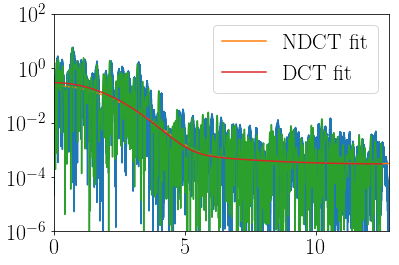

In [7]:
plt.semilogy(w_PSD[1:],P_PSD[1:])
#plt.semilogy(w_PSD,Pnoise)
#plt.semilogy(w_PSD,Psignal)
plt.semilogy(w_PSD,P_fit,label='NDCT fit')
plt.gca().set(ylim=(1e-6,100), xlim=(min(w_PSD),max(w_PSD)))

plt.semilogy(w_PSD1[1:],P_PSD1[1:])
#plt.semilogy(w_PSD1,Pnoise1)
#plt.semilogy(w_PSD1,Psignal1)
plt.semilogy(w_PSD1,P_fit1, label='DCT fit')
plt.legend()

#### Deconvolve/back diffuse the data by NDCT and DCT. Set sigma to something

In [11]:
sigma = 0.0711

t1, a1 = deconInst1.deconvolve(sigma)
t, a = deconInst.deconvolve(sigma)


254


#### Plot data and NDCT/DCT deconvolved data.

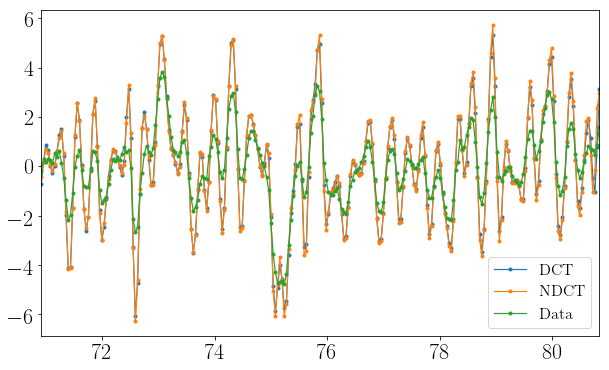

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(t1,a1, label='DCT', lw=1.2, marker='.')
#plt.plot(depth_LT,data_decon, label='NDCT', lw=1.2, marker='.')

plt.plot(t,a, label='NDCT', lw=1.2,marker='.')
plt.plot(depth_LT, d18O_LT-np.mean(d18O_LT), label='Data', lw=1.2, marker='.')
plt.gca().set(xlim=(min(depth_LT),max(depth_LT)))
plt.legend(fontsize=16)


# Testing on generic periodic function

In [11]:
import math
def Ndct(depth,data, N_min):

    if data.size < N_min:
        N = math.ceil(N_min/data.size) * data.size
    else:
        N = data.size

    dt = np.mean(np.diff(depth))
    freq = np.fft.fftfreq(2*N, dt)[:(2*N)//2]

    D = np.cos(np.outer(2*np.pi*freq,(depth + 1/(2*N))))

    NDCT = 2*D.dot(data)
    NDCT[0] = NDCT[0]*np.sqrt(1/(4*N))
    NDCT[1:] = NDCT[1:]*np.sqrt(1/(2*N))

    return freq, NDCT

def INdct(depth,freq, Amp):

    N = freq.size
    Di = np.cos(np.outer((depth + 1/(2*N)), 2*np.pi*freq[1:]))
    s = Amp[0]/np.sqrt(N) + np.sqrt(2/N) * Di.dot(Amp[1:])

    return s

In [12]:
def fct(x):
    y = np.sin(5*x) + 3*np.cos(np.pi*x) + 0.2*np.random.random(len(x))
    return y

In [13]:
xStart = 0
xEnd = 30
Npoints = 201
delta = (xEnd - xStart)/Npoints

x_uni = np.linspace(xStart,xEnd,Npoints)
y_uni = fct(x_uni)

x_Nuni = np.linspace(xStart,xEnd,Npoints) + (delta/4) * np.random.random(Npoints)
y_Nuni = fct(x_Nuni)

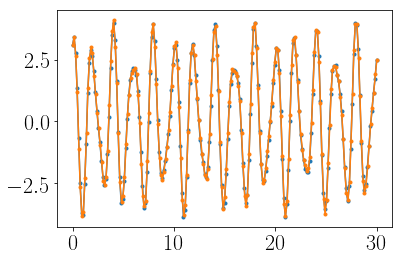

In [14]:
plt.plot(x_uni, y_uni,marker='.')
plt.plot(x_Nuni, y_Nuni,marker='.')

In [15]:
Y_uni = sp.fft.dct(y_uni, 2, norm='ortho')
_, Y_Nuni = Ndct(x_Nuni, y_Nuni, 20)

N = x_uni.size
dt = np.mean(np.diff(x_Nuni))
w = np.fft.fftfreq(2*N, dt)[:(2*N)//2]

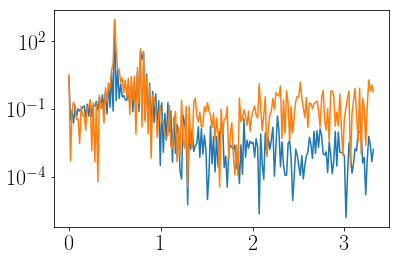

In [16]:
plt.semilogy(w, abs(Y_uni)**2)
plt.semilogy(w, abs(Y_Nuni)**2)

In [128]:
y_uniBD = sp.fft.dct(Y_uni, 3, norm='ortho')
y_NuniBD = INdct(x_Nuni, w, Y_Nuni)

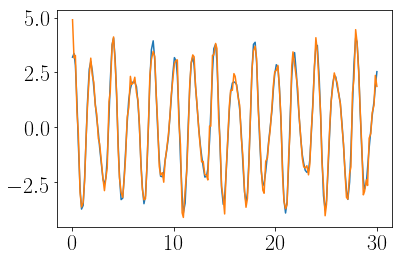

In [137]:
#plt.plot(x_uni, y_uni)
#plt.plot(x_uni, y_uniBD)
plt.plot(x_Nuni,y_Nuni)
plt.plot(x_Nuni, y_NuniBD)
